In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
import tushare as ts

cons = ts.get_apis()
df = ts.bar('000300', conn=cons, asset='INDEX', start_date='2002-01-01', end_date='')

# 注意历史数据靠前
df = df.sort_index(ascending=True)
df.to_csv('sh.csv')

# 可以看出，周末不进行交易
df.head(20)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


AttributeError: 'NoneType' object has no attribute 'sort_index'

In [ ]:
df = pd.read_csv('sh.csv', index_col=0)
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,code,open,close,high,low,vol,amount,p_change
2005-01-04,300,994.76,982.79,994.76,980.65,74128.0,4.431976e+09,NaN
2005-01-05,300,981.57,992.56,997.32,979.87,71191.0,4.529207e+09,0.99
2005-01-06,300,993.33,983.17,993.78,980.33,62880.0,3.921015e+09,-0.95
2005-01-07,300,983.04,983.95,995.71,979.81,72986.0,4.737468e+09,0.08
2005-01-10,300,983.76,993.87,993.95,979.78,57916.0,3.762931e+09,1.01


In [ ]:
def getData(df, column, train_end=-300, days_before=30, return_all=True, generate_index=False):
    '''
    读取原始数据，并生成训练样本
    df             : 原始数据
    column         : 要处理的列
    train_end      : 训练集的终点
    days_before    : 多少天来预测下一天
    return_all     : 是否返回所有数据，默认 True
    generate_index : 是否生成 index
    '''
    series = df[column].copy()
    
    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series, test_series = series[:train_end], series[train_end - days_before:]
    
    # 创建训练集
    train_data = pd.DataFrame()
        
    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7
        train_data['c%d' % i] = train_series.tolist()[i: -days_before + i]
            
    # 获取对应的 label
    train_data['y'] = train_series.tolist()[days_before:]
        
    # 是否生成 index
    if generate_index:
        train_data.index = train_series.index[n:]
                
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [ ]:
class TrainSet(Dataset):
    def __init__(self, data):
        # 定义好 image 的路径
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [ ]:
LR = 0.0001
EPOCH = 100
TRAIN_END=-300
DAYS_BEFORE=7

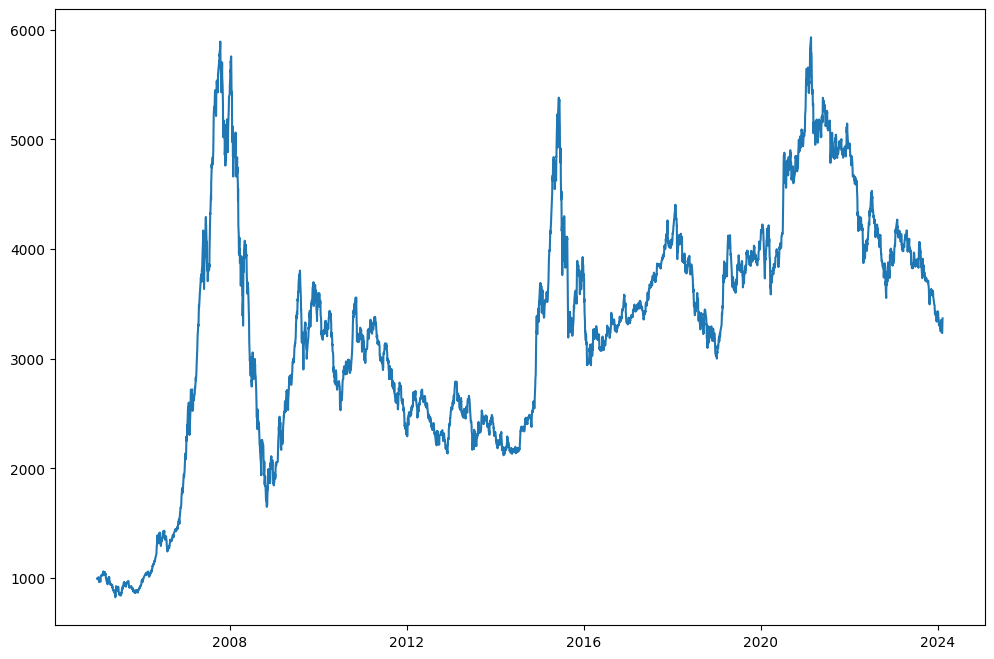

In [ ]:
# 数据集建立
train_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, train_end=TRAIN_END)

# 获取所有原始数据
all_series = np.array(all_series.tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')

# 归一化，便与训练
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

# 创建 dataloader
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [ ]:
rnn = LSTM()

if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in train_loader:
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()       
        
        output = rnn(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

0 tensor(0.0228, grad_fn=<MseLossBackward0>)
1 tensor(0.0052, grad_fn=<MseLossBackward0>)
2 tensor(0.0027, grad_fn=<MseLossBackward0>)
3 tensor(0.0024, grad_fn=<MseLossBackward0>)
4 tensor(0.0083, grad_fn=<MseLossBackward0>)
5 tensor(0.0168, grad_fn=<MseLossBackward0>)
6 tensor(0.0151, grad_fn=<MseLossBackward0>)
7 tensor(0.0090, grad_fn=<MseLossBackward0>)
8 tensor(0.0197, grad_fn=<MseLossBackward0>)
9 tensor(0.0017, grad_fn=<MseLossBackward0>)
10 tensor(0.0151, grad_fn=<MseLossBackward0>)
11 tensor(0.0016, grad_fn=<MseLossBackward0>)
12 tensor(0.0034, grad_fn=<MseLossBackward0>)
13 tensor(0.0032, grad_fn=<MseLossBackward0>)
14 tensor(0.0017, grad_fn=<MseLossBackward0>)
15 tensor(0.0056, grad_fn=<MseLossBackward0>)
16 tensor(0.0022, grad_fn=<MseLossBackward0>)
17 tensor(0.0004, grad_fn=<MseLossBackward0>)
18 tensor(0.0037, grad_fn=<MseLossBackward0>)
19 tensor(0.0033, grad_fn=<MseLossBackward0>)
20 tensor(0.0034, grad_fn=<MseLossBackward0>)
21 tensor(0.0093, grad_fn=<MseLossBackward0>

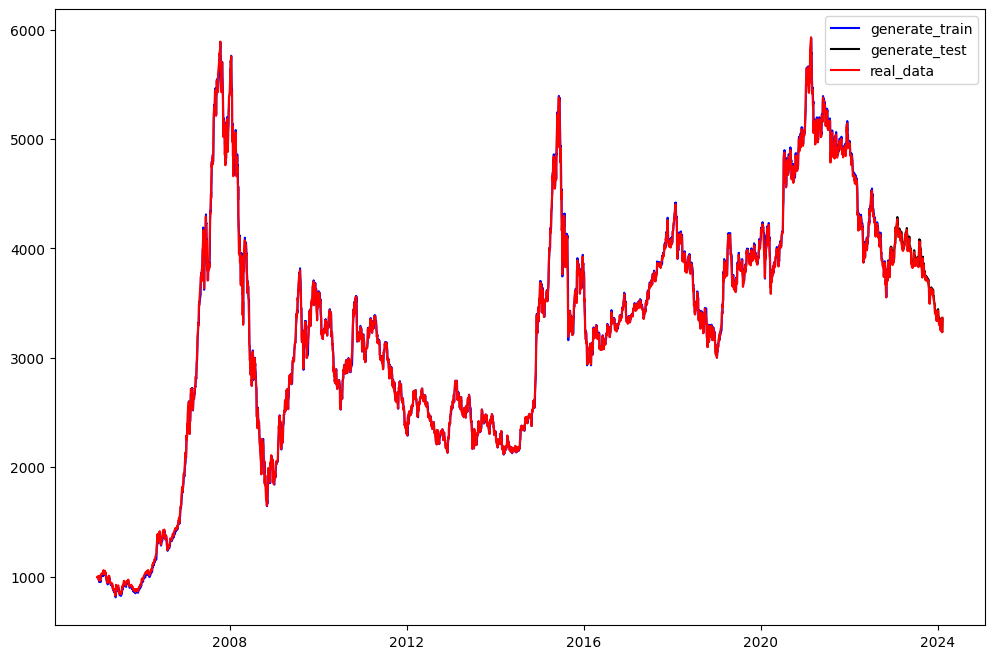

In [ ]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = rnn(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series.clone().numpy()* train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

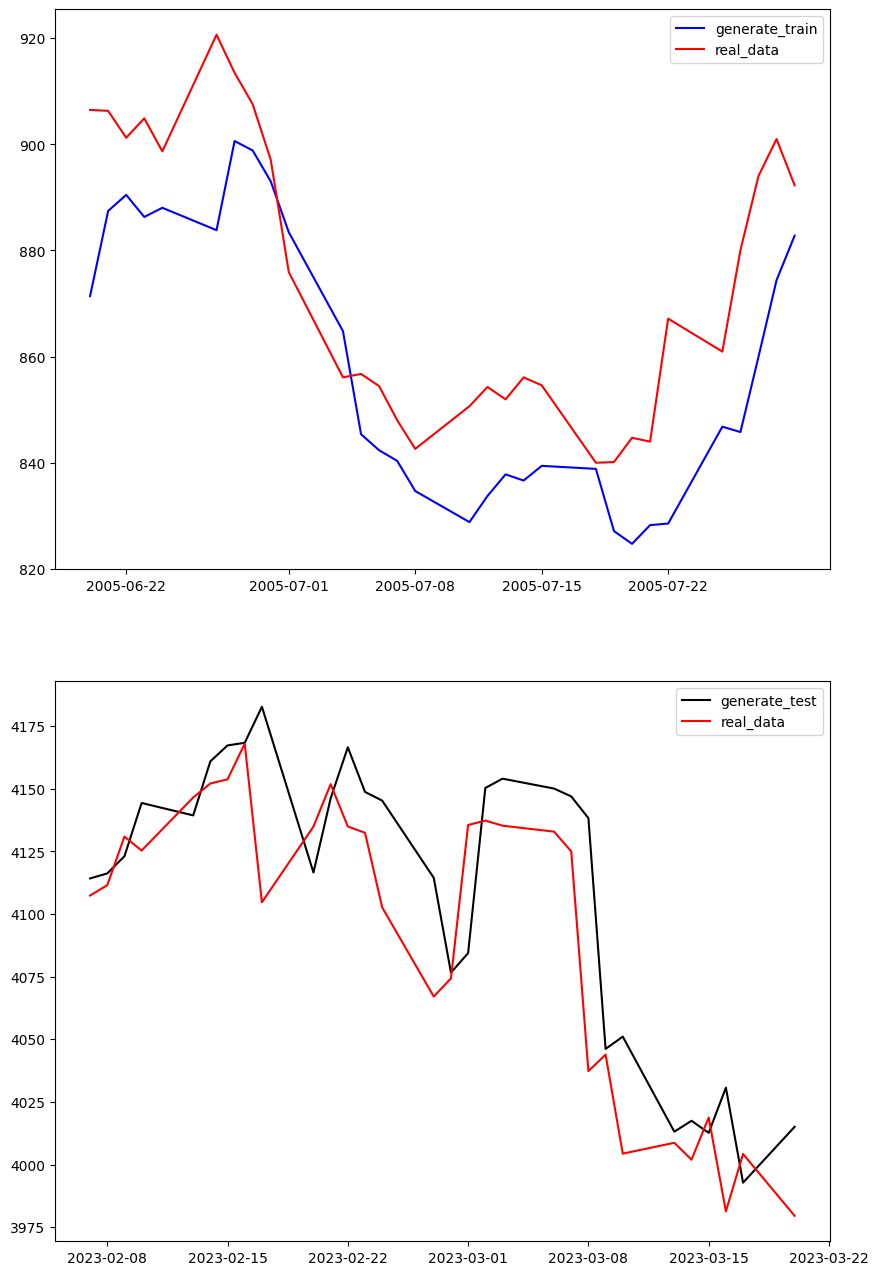

In [ ]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], generate_data_test[50:80], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], (all_series.clone().numpy()* train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80], 'r', label='real_data')
plt.legend()

plt.show()